## Nesterov smoothing

### Importing libraries

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib as mpl
from random import shuffle
import pandas as pd

### Semi discrete optimal transport

<font color="blue">
$$
\begin{align}
\text{min} \big\{ \int_X \sum_j c_{T}(x, y_j) d\gamma_j(x) : \int_X d\gamma_j(x) = \nu_j, \sum_j d\gamma_j(x) = d\mu(x) \big\}
\end{align}
$$
</font>

where
- $\mu(x) \sim X$ is a continuous distribution
- $\nu \sim Y$ is a discrete distribution
- $c_T(x, y_j) = \frac{1}{2}(x - y_j)^2$ is the cost function

### Generate a problem

**Continuous distribution $\mu(x) \sim X = N(0, 1)$ and a discrete distribution $\nu \sim Y$**

In [2]:
data = pd.read_csv("../datasets/gaussians.csv")
x = data["x"]
y = data["y"]
n = data.shape[0]
m = data.shape[0]

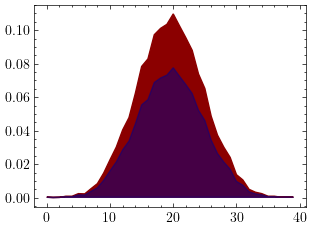

In [3]:
plt.fill(y, color = "darkred")
plt.fill(x, color = "darkblue", alpha = 0.5)
plt.show()

### Distance matrix

$$C = d(x_i, y_j) = \frac{1}{2}(x_i - y_j)^2$$

$$i = \{1, 2, \ldots, m\} \ \text{and} \ j = \{1, 2, \ldots, n\}$$

In [4]:
C = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        C[i, j] = .5 * (x[i] - y[j])**2

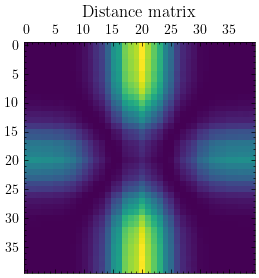

In [5]:
fig,ax = plt.subplots(figsize=(3, 3))
ax.matshow(C)
plt.title("Distance matrix")
plt.show()

### Dual formulation

<font color="blue">
$$\sup_{\psi, \phi} \big\{ \sum_j\psi_j\nu_j + \int_X \phi(x) d\mu(x) : \psi_j + \phi(x) \leq c(x, y_j) \big\}$$
</font>

which is equivalent to

<font color="blue">
$$\sup_{\psi} \big\{ \sum_j\psi_j\nu_j + \int_X \inf_{j}[c(x, y_j) - \psi_j] d\mu(x) \big\}$$
</font>


This loss function is **non-smooth**, here we approximate it with a smooth function

**Objective function**

<font color="blue">
$$J(\psi) = \sum_j \psi_j \nu_j + \sum_i \inf_j [c_{i,j} - \psi_j]\mu_i$$
</font>

with $\psi = (\psi_1, \psi_2, \ldots, \psi_N) \in R^N$

Let's approximate it with a smooth functions

let
$$\phi_i = \psi^{c}(x_i) = \inf_j [c_{i,j} - \psi_j ]$$

Now we have the following uncontrained problem

<font color="blue">
$$\sup_\psi J(\psi) = \sup_j \sum_j \psi_j \nu_j + \sum_i \psi^{c}(x_i) \mu_i $$
</font>

with $\psi = (\psi_1, \psi_2, \ldots, \psi_N) \in R^N$

if $\psi^*$ is a solution, then

$$
\begin{align}
J(\psi^* + k\mathbb{1}) &= \sum_j (\psi_j^* + k\mathbb{1}) \nu_j+ \sum_i \phi_i \mu_i \\
                        &= \sum_j \psi_j^* \nu_j + \sum_i \phi_i \mu_i + k\sum_j\nu_j \\
                        &= \sum_j \psi_j^* \nu_j + \sum_i \phi_i \mu_i + k
\end{align}
$$


so $J(\psi^* + k\mathbb{1}) \geq J(\psi^*)$, therefore $\psi^* + k\mathbb{1}$ is also a solution

Let's add another term $H$ to make the solution unique

function

<font color="blue">
$$
\sup_{\psi} \mathbb{E} = \sup_{\psi}J + I_{H}(\psi)
$$
</font>

where $H =\{ \psi : \sum_j \psi_j = 0\}$, with $I_H(\psi) = 0$  if $\psi \in H$, else $\infty$

Let's approximate $\psi^c(x_i)$ by a smooth function

**Nesterov smoothing**

a function $f = \max \{x_1, x_2, ..., x_n\}$ is approximated by 
$$f_\lambda(x) = \lambda \log ( \sum_{j=1}^{n}\exp^{x_j/\lambda} ) - \lambda \log n$$

An approximation of $\psi^{c}(x_i)$ is given by

$$\psi^c(x_i) = \inf_j [c_{i,j} - \psi_j] = \sup_j [\psi_j - c_{i,j}] = \max_j [\psi_j - c_{i,j}]$$

then an approximation of $\psi^c(x_i)$ is

<font color="blue">
$$\phi^c_{\lambda}(x_i) = \lambda \log \sum_{j=1}^{n} \exp^{(\psi_j - c_{i,j}) / \lambda} - \lambda \log n$$
</font>

The nesterov smoothing is

$$
J_{\lambda}(\psi) = \sum_{j} \psi_j \nu_j + \sum_i \mu_i \left( \lambda \log \sum_{j=1}^{n} \exp^{(\psi_j - c_{i,j}) / \lambda} - \lambda \log n \right)
$$

the smoot objective function is

<font color="blue">
$$
J_{\lambda}(\psi) = \sum_{j=1}^{n} \psi_j \nu_j
+ \lambda \sum_{i=1}^{m} \mu_i \log (\sum_{j=1}^{n} \exp^{\dfrac{\psi_j - c_{i,j}}{\lambda}} )
- \lambda \log n
+ I_H(\psi)
$$
</font>

In [6]:
def obj(psi, lbda, mu, nu):
    loss = 0.
    for j in range(n):
        loss += psi[j] * nu[j]
    loss_1 = 0.
    for i in range(m):
        rlog = 0.
        for j in range(n):
            rlog += math.exp((psi[j] - C[i,j]) / lbda)
        rlog = mu[i] * math.log(rlog)
        loss_1 += rlog
    loss += lbda * loss_1
    loss -= lbda * math.log(n)
    return loss

**Gradient of the objective function**

The gradient is given by

$$
\dfrac{\partial J_\lambda(\psi)}{\partial\psi_k} =
\nu_k
+ \lambda \sum_i \mu_i \dfrac{ \dfrac{\partial}{\partial \psi_k} \sum_{j=1}^{n} \exp^{(\psi_j - c_{i,j}) / \lambda} }
{\sum_j \exp^{(\psi_j - c_{i,j})/\lambda}}
+ \dfrac{\partial}{\partial \psi_k} I_H(\psi)
$$

for $k \in \{1, ..., n\}$

$$
\dfrac{\partial J_\lambda(\psi)}{\partial\psi_k} =
\nu_k
+ \sum_i \mu_i \dfrac{ \exp^{(\psi_k - c_{i,k}) / \lambda} }
{\sum_j \exp^{(\psi_j - c_{i,j})/\lambda}}
$$

<font color = "blue">
$$
\nabla J_\lambda(\psi) =
\left( \ldots, \nu_k
+ \sum_i \mu_i \dfrac{ \exp^{(\psi_k - c_{i,k}) / \lambda} }
{\sum_j \exp^{(\psi_j - c_{i,j})/\lambda}}, \ldots \right)
$$
</font>

In [7]:
def project(z, n):
    return z - z.sum()/n

In [8]:
def grad(psi, n, m, lbda, mu, nu):
    jgrad = np.zeros(n)
    for k in range(n):
        jgrad[k] = nu[k]
        for i in range(m):
            denom = 0.
            for j in range(n):
                denom += math.exp((psi[j] - C[i, j]) / lbda)
            num = math.exp((psi[k] - C[i, k])/lbda)
            jgrad[k] += mu[i] * num / denom
    return jgrad

**Optimization algorithm**

The loss function can be optimized by the Fast Proximal Gradient Method (FISTA)
1. Set $\psi^0 = \mathbf{0}$, $\theta_0 = 1$, $\eta_t = \lambda$
2. $z^{t+1} = \pi_{\eta_t I_H}(\psi^t - \eta_t \nabla J_{\lambda}(\psi^t))$
3. $\theta_{t+1} = 1/2(1 + \sqrt(1 + 4\theta_t^2))$
4. $\psi^{t+1} = z^{t+1} + \dfrac{\theta_t - 1}{\theta_{t+1}}(z^{t+1} - z^t)$

$\pi_{\eta_t I_H}(z) = z - \dfrac{1}{n} \sum_{j=1}^{n}z_j$ is the projection of $z$ to $I_H$

In [9]:
def optimize(lbda, mu, nu, m, n, itermax = 10, eps = 1e-5):
    psi0 = np.zeros(m)
    z0 = np.zeros(m)
    theta0 = 1
    eta_t = lbda
    loss0 = 0.
    hist_loss = []
    for t in range(itermax):
        psi0 = project(psi0, n)
        jgrad = grad(psi0, n, m, lbda, mu, nu)
        theta_t = 0.5 * (1 + math.sqrt(1 + 4 * theta0**2))
        z_t = project(psi0 - eta_t * jgrad, n)
        psi_t = z_t + (theta0 - 1)  * (z_t - z0) / theta_t
        # Loss
        loss = obj(psi_t, lbda, x, y)
        hist_loss += [loss]
        # Update parameters
        theta0 = theta_t
        psi0 = psi_t
        theta0 = theta_t
        # check for convergence
        if abs(loss - loss0) < eps:
            print("Convergence at epoch {}".format(t))
            break
        else:
            loss0 = loss
    return psi0, hist_loss

**Optimization for different values of $\lambda$**

In [10]:
lbda = 1e-3
res = optimize(lbda, x, y, m, n, 10)

In [11]:
psi_star = res[0]
hist_loss = res[1]

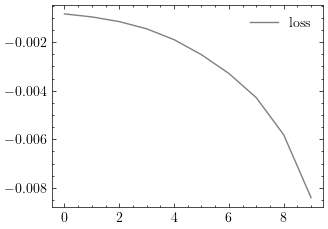

In [12]:
plt.plot(hist_loss, color = "gray", label = "loss")
plt.legend()
plt.show()

In [13]:
psi_star = res[0]

### Optimal transport plan

$$
(P_{\lambda}^{*})_{i,k} = \mu_i \dfrac{\exp^{((\psi_{\lambda}^{*})_{k} - c_{i,k})/\lambda}}
{\sum_{j=1}^{n} \exp^{((\psi_{\lambda}^{*})_{j} - c_{i,j})/\lambda}}
$$

In [14]:
def optimal_transport_plan(psi_star, lbda, mu, nu, n):
    P = np.zeros((n,m))
    for i in range(n):
        for k in range(m):
            P[i,k] = mu[i] * math.exp((psi_star[k] - C[k, i]) / lbda)
    return P

In [15]:
P = optimal_transport_plan(psi_star, 0.1, x, y, n)

In [16]:
P /= P.sum()

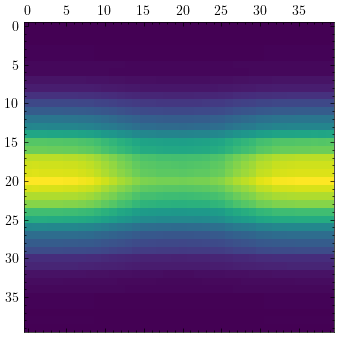

In [17]:
plt.matshow(P)
plt.show()

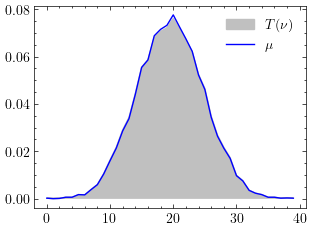

In [18]:
plt.fill(P.sum(1), color = "silver", label = r"$T(\nu)$")
plt.plot(x, color = "blue", label = r"$\mu$")
plt.legend()
plt.show()